# Visualise a generational histogram displaying the cell cycle duration:

### Motivation:

Before we start analysis the relationships of cell cycle durations in cell families, it is important to get familiar with how to process the data. check whether we can detect any distribution of the cycling times. _This is what this notebook is for._

### Background:

For previous work on this topic, have a look at our recent lab publications at [Ulicna et al., 2020](https://www.biorxiv.org/content/10.1101/2020.09.10.276980v1 "Automated deep lineage tree analysis using a Bayesian single cell tracking approach") & [Bove et al., 2017](https://www.molbiolcell.org/doi/full/10.1091/mbc.E17-06-0368?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed "Local cellular neighborhood controls proliferation in cell competition")

### Guidelines:

When processing the single cell data, do the following:
+ Exclude generations #7 and higher: only include generations #1, #2, #3, #4, #5, #6 in the histogram
+ Only include fully resolved cell which are non-root & non-leaf (their whole intermitotic time was imaged)
+ Range the histogram to cells with cycling time from 7 to 42 hours (including)
+ With the abovementioned range, you get the histogram of _over 600 cells!_ per movie **Cool!!!**


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py


In [2]:
hdf5_file = "../example_segment_classif_tracked_movie.hdf5"


### Let's open the file & read the cell details for six generations:

In [3]:
generations = 6
cct = [[] for _ in range(generations)]

with h5py.File(hdf5_file, 'r') as f:
    for cell in f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"]:
        
        # This large 'if' statement filters all unwanted tracklets which are not true cells:
        if cell[0] != 0 and cell[1] != 0 and cell[2] != 0 and cell[2] < 7 and 7.0 <= cell[3] <= 42.0:
            cct[int(cell[2])-1].append(float(cell[3]))


### Calculate & print out some generational statistics:

Interesting numbers to have a look at regarding cell cycle duration: _cell count, mean, standard deviation, minimum duration, maximum duration_



In [4]:
lng, mean, std, mn, mx = [[0 for _ in range(generations)] for _ in range(5)]

for enum, gen in enumerate(cct):
    
    lng[enum] = len(gen)
    if len(gen) > 1:
        mean[enum] = round(np.mean(gen), 4)
        std[enum] = round(np.std(gen), 4)
        mn[enum] = round(np.min(gen), 4)
        mx[enum] = round(np.max(gen), 4)
    elif len(gen) == 1:
        mean[enum] = round(gen[0], 4)
        std[enum] = 0.0
        mn[enum] = round(gen[0], 4)
        mx[enum] = round(gen[0], 4)
    else:
        mean[enum] = 0.0
        std[enum] = 0.0
        mn[enum] = 0.0
        mx[enum] = 0.0


In [5]:
print (f"Cell Count in Specified Range <7, 42> hours\n")

for e, (l, m, s, n, x) in enumerate(zip(lng, mean, std, mn, mx)):
    print ("Cells in Gen#{}\t-> {}\tMean = {}\tSt.dev = {}\tMin = {}\tMax = {}".format(e + 1, l, m, s, n, x))
    


Cell Count in Specified Range <7, 42> hours

Cells in Gen#1	-> 141	Mean = 17.4066	St.dev = 4.4001	Min = 10.4	Max = 34.0
Cells in Gen#2	-> 188	Mean = 16.6358	St.dev = 4.1804	Min = 10.6667	Max = 41.4667
Cells in Gen#3	-> 221	Mean = 16.5653	St.dev = 3.5254	Min = 9.4	Max = 29.5333
Cells in Gen#4	-> 116	Mean = 15.3305	St.dev = 2.5277	Min = 11.0667	Max = 24.0667
Cells in Gen#5	-> 11	Mean = 14.8545	St.dev = 2.0648	Min = 12.2	Max = 19.4
Cells in Gen#6	-> 0	Mean = 0.0	St.dev = 0.0	Min = 0.0	Max = 0.0


**Cool!**

As you can see for yourself, there are cells in generations #1-#4 or reasonable _n_ numbers, in the order of 100s. Generation #5 is quite rare (only 11 cells) as expected. Generation #6 is empty, so let's skip this one when plotting it out!

### Plot the generational histograms for Gens #1-6:

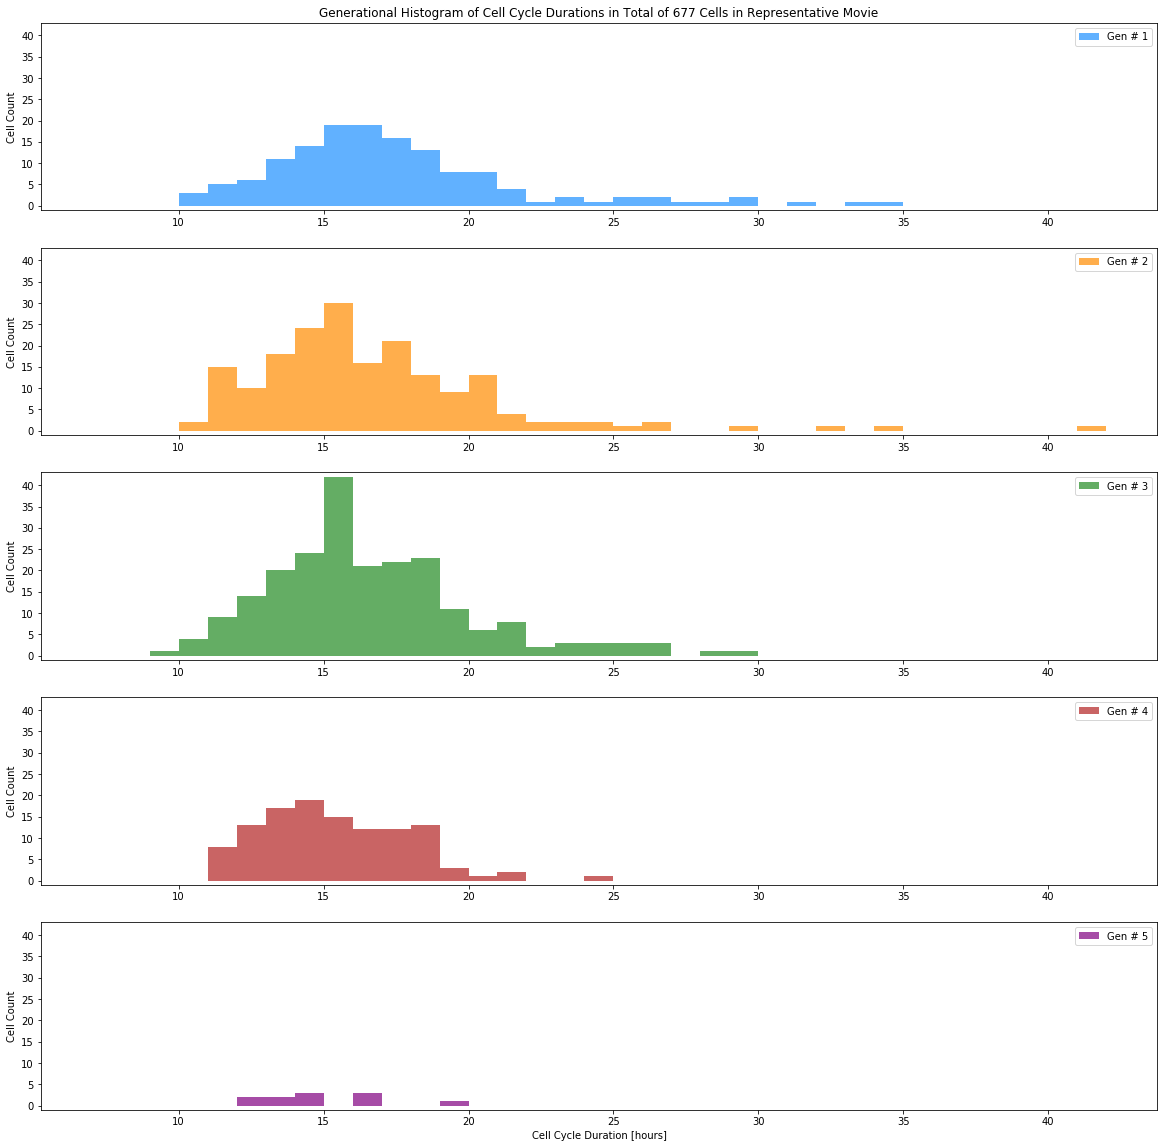

In [6]:
fig, axs = plt.subplots(figsize=(20, 20), nrows=5, ncols=1, sharey=True)

colors = ["dodgerblue", "darkorange", "forestgreen", "firebrick", "purple"]

cells_in_hist = 0
for enum, (generation, color) in enumerate(zip(cct[:-1], colors)):
    bin_count, b, c = axs[enum].hist(generation, bins=35, range=(7, 42), color=color, alpha=0.7, label=f"Gen # {enum+1}")
    cells_in_hist += int(sum(bin_count))
    axs[enum].set_ylabel(f"Cell Count")
    axs[enum].legend(loc="best")
    axs[enum].set_ylim(-1, 43)
    
axs[0].set_title("Generational Histogram of Cell Cycle Durations in Total of {} Cells in Representative Movie".format(cells_in_hist, generations))
plt.xlabel("Cell Cycle Duration [hours]")
#plt.savefig("hist_generational.pdf", bbox_to_inches="tight")
plt.show()
plt.close()


### Check how many fast, medium & slow dividers:

You probably read in our preprint that we defined the cells into 3 categories: **fast** dividers, **medium** dividers & **slow** dividers, according to the cell cycling duration (also called _intermitotic time_, which stands for the time elapsed between 2 subsequent cell divisions). 

By definition:
+ the **fast** dividers divide in less than mean - 1/2 standard deviation, 
+ the **medium** dividers divide between mean - 1/2 standard deviation & mean + 1/2 standard deviation
+ the **slow** dividers divide in more than mean + 1/2 standard deviation 

...away from the overall population.


In [7]:
# Normal distribution?
cct_collection = [item for sublist in cct for item in sublist]
mean_flat, std_flat = np.mean(cct_collection), np.std(cct_collection)

categories = [0 for _ in range(3)]
for i in cct_collection:
    if i < mean_flat - (std_flat/2):
        categories[0] += 1
    if mean_flat - (std_flat/2) <= i <= mean_flat + (std_flat/2):
        categories[1] += 1
    if mean_flat + (std_flat/2) < i:
        categories[2] += 1

# Print the stats:
print (f"Ranged population of {len(cct_collection)} cells: mean ± st.dev = {mean_flat} ± {std_flat}")
print (f"Cells below, between & above mean ± 1/2  standard deviations {categories} -> {[round(item * 100 / len(cct_collection), 2) for item in categories]}%")
       

Ranged population of 677 cells: mean ± st.dev = 16.52073028064993 ± 3.816043231717333
Cells below, between & above mean ± 1/2  standard deviations [223, 297, 157] -> [32.94, 43.87, 23.19]%


### Plot the overall histograms including merged data from Gens #1-6 with cell counts & bin probability:

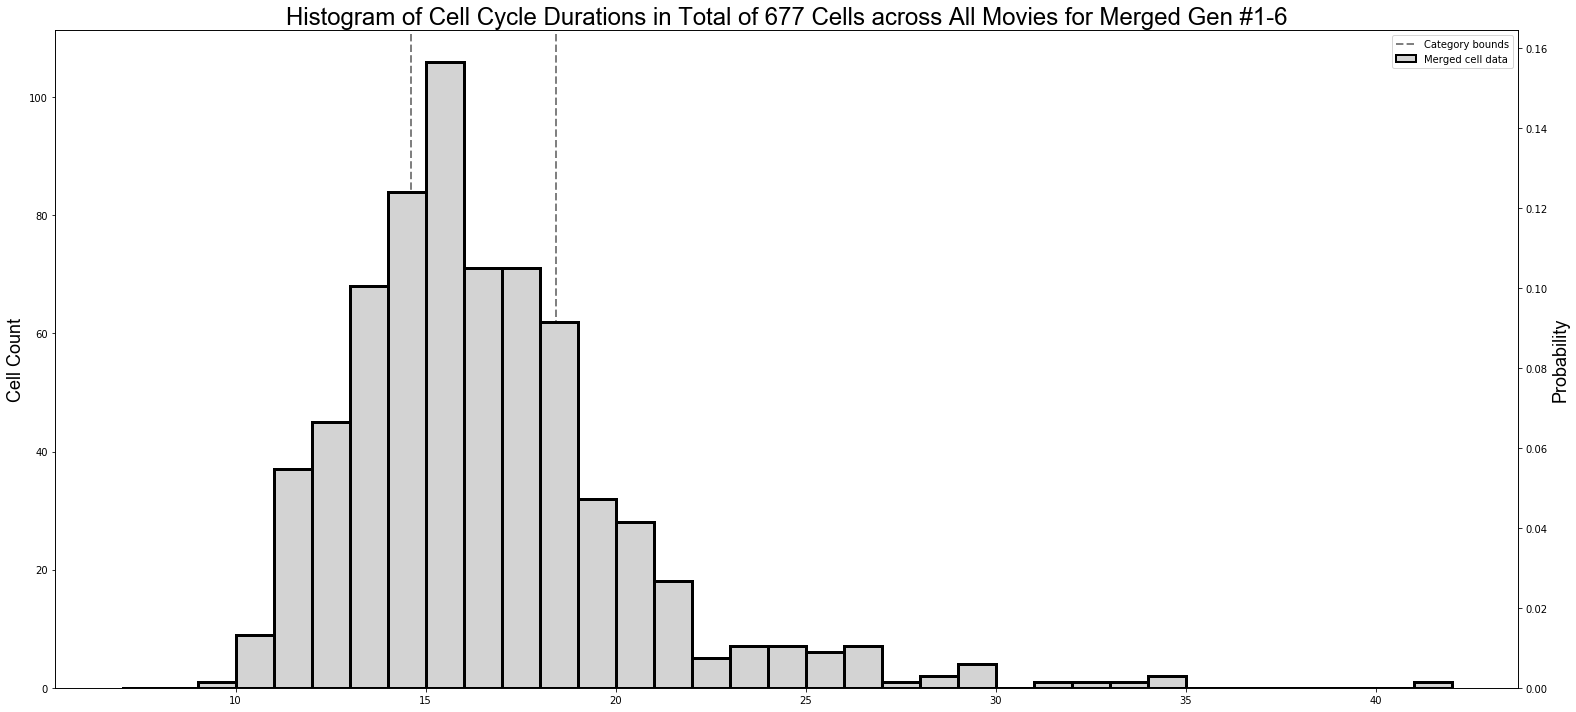

In [8]:
fig, ax1 = plt.subplots(figsize=(22, 10))

cells_in_hist = 0
cct_flat = [item for sublist in cct[0:6] for item in sublist]
mean_flat = np.mean([item for item in cct_flat if 7.0 <= item <= 42.0])
std_flat = np.std([item for item in cct_flat if 7.0 <= item <= 42.0])

bin_count, b, c = ax1.hist(cct_flat, bins=35, range=(7, 42), color="lightgray", alpha=1.0, linewidth=2.0, linestyle='-', edgecolor="black", label="Merged cell data")
ax1.set_ylabel("Cell Count", fontname="Arial", fontsize=18)
ax1.axvline(x=mean_flat-0.5*std_flat, linestyle="dashed", linewidth=2.0, color="grey", label="Category bounds")
ax1.axvline(x=mean_flat+0.5*std_flat, linestyle="dashed", linewidth=2.0, color="grey")

ax2 = ax1.twinx()
bin_count_prob, b, c = ax2.hist(cct_flat, bins=35, range=(7, 42), density=True, color="lightgray", alpha=1.0, linewidth=3.0, linestyle='-', edgecolor="black")
ax2.set_ylabel("Probability", fontname="Arial", fontsize=18)

plt.title("Histogram of Cell Cycle Durations in Total of {} Cells across All Movies for Merged Gen #1-6".format(int(sum(bin_count))), fontname="Arial", fontsize=24)
plt.xlabel("Cell Cycle Duration [hours]", fontname="Arial", fontsize=18)
plt.xticks(fontname="Arial", fontsize=20)

ax1.legend()
plt.tight_layout()
plt.show()
plt.close()


### Done!